---
title: "Class Session 11 - Naive Bayes"
author: "Trent VanHawkins"
date: today
format: 
    pdf:
        geometry: "margin=0.75in"
        mathspec: true
        code-overflow: wrap
        cap-location: bottom
        tbl-cap-location: bottom
        header-includes: 
        - \usepackage{fancyhdr, amsthm, amssymb,amsfonts,amsthm, amsmath, bbm}
        - \usepackage{float, tabularx}
        - \floatplacement{table}{H}
        - \pagestyle{fancy}
        - \fancyhead[R]{Notebook 11}
        - \fancyhead[L]{Trent VanHawkins}
        - \fancyfoot[C]{\thepage} # Center page number at bottom of each page
page-layout: full
execute: 
  eval: true
---

Download the synthetic classification dataset from URL `https://csx46.s3-us-west-2.amazonaws.com/naive-bayes-example.tsv` as a TSV file `naive-bayes-example.tsv`:

In [1]:
!curl https://csx46.s3-us-west-2.amazonaws.com/naive-bayes-example.tsv > ../DataRaw/naive-bayes-example.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  214k  100  214k    0     0   527k      0 --:--:-- --:--:-- --:--:--  527k


Import `math`, `numpy` and `pandas`

In [3]:
import pandas as pd
import numpy as np
import math

Using `pandas.read_csv`, load the TSV file as a `pandas.DataFrame` called `df`

In [ ]:
df = pd.read_csv("../DataRaw/naive-bayes-example.tsv", sep="\t")

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,y
0,0,0,0,0,1,0,1,0,0,1,0
1,1,0,1,0,1,0,1,1,0,1,0
2,1,1,0,0,0,0,1,0,0,1,0
3,1,0,1,0,1,0,0,1,0,0,0
4,1,0,1,0,1,0,1,0,0,0,0


Take a peek at `df` using the `pandas.DataFrame.head` method:

In [5]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,y
0,0,0,0,0,1,0,1,0,0,1,0
1,1,0,1,0,1,0,1,1,0,1,0
2,1,1,0,0,0,0,1,0,0,1,0
3,1,0,1,0,1,0,0,1,0,0,0
4,1,0,1,0,1,0,1,0,0,0,0


What is the shape of `df`?  So how many features `P` are there, and how many samples `N` are there?  Are we working on a `P > N` machine-learning problem or a `N > P` problem?

In [6]:
df.shape

(10000, 11)

We have $N = 10,000$ observations and $P = 10$ features, so we are certainly *not* in an $P>>N$ scenario.

Assign the values `N` and `P` to the numbers of rows and feature columns of `df` (note, we do not count the final column `y` of `df` as a feature column, so you'll have to subtract 1 in order to get `P`).

In [7]:
N = df.shape[0]
P = df.shape[1] - 1

print(f"N: {N}")
print(f"P: {P}")

N: 10000
P: 10


Iterate over the data frame as `col` (which will give you a `pandas.Series` object `col` for each column, one at a time), and print both `col` and `df[col].unique()` to get the unique values of each column. This is a nice way to check if there are missing data or unexpected data in the file. Does it look like clean binary data?  Note that this data file was generated using the R programming language, so the column names go from `X1` to `X10` and then `y` (which is the binary class label).

In [8]:
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

X1: [0 1]
X2: [0 1]
X3: [0 1]
X4: [0 1]
X5: [1 0]
X6: [0 1]
X7: [1 0]
X8: [0 1]
X9: [0 1]
X10: [1 0]
y: [0 1]


For each column in `df` as variable `col`, compute the counts of the values 0 and 1 for that column using the `pandas.Series.value_counts` method, and print it out.

In [12]:
for col in df.columns: 
    print(pd.Series.value_counts(df[col]))

X1
1    6698
0    3302
Name: count, dtype: int64
X2
0    7454
1    2546
Name: count, dtype: int64
X3
0    5461
1    4539
Name: count, dtype: int64
X4
0    6340
1    3660
Name: count, dtype: int64
X5
1    8490
0    1510
Name: count, dtype: int64
X6
0    7170
1    2830
Name: count, dtype: int64
X7
1    7415
0    2585
Name: count, dtype: int64
X8
0    6381
1    3619
Name: count, dtype: int64
X9
0    7992
1    2008
Name: count, dtype: int64
X10
0    5334
1    4666
Name: count, dtype: int64
y
0    9467
1     533
Name: count, dtype: int64


What is the class balance `B` of this dataset, defined as the ratio of the number of entries in column `y` with value = 1 to the number of entries in column `y` with value = 0?

In [21]:
Ny1 = sum(df['y'] == 1)
Ny0 = sum(df['y'] == 0)

print(f"The class balance is: {Ny1/Ny0 : .3f}", )

The class balance is:  0.056


Using `numpy.full`, define a `numpy.array` of size 2xP called `llr` to hold the log-likelihood ratios; initialize it to all `np.nan` for now.

In [30]:
llr = np.full(shape=(2,P), fill_value=np.nan)

Take a peek at `llr` to make sure you created it correctly

In [31]:
llr

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

Compute the log-likelihoods `llr`, one column at a time, using a `for` loop over integer column numbers `p` in `range(0,P)`. I will walk you through the steps using comments within the `for` loop.

In [34]:
for p in range(0,P):
  # Use `pandas.DataFrame.iloc[:,p]` to grab column `p` of the dataframe `df`
  # and build a Nx2 dataframe `subdf` consisting of that column plus the `y`
  # column of `df`, using the `pd.DataFrame` dictionary-type constructor
  subdf = pd.DataFrame({'x': df.iloc[:,p], 'y': df['y']})
  # call `pandas.DataFrame.value_counts` on `subdf` and assign to `subdf_vc`
  subdf_vc = subdf.value_counts()
  # then use row/column indexing into `subdf_vc` using the `.loc` member
  # for all combinations `[1,0]`, `[0,0]`, `[1,1]`, and `[0,1]` and assign
  # the results to `nx1y0`, `nx0y0`, `nx1y1`, and `nx0y1`, respectively.
  nx1y0 = subdf_vc.loc[1, 0]
  nx0y0 = subdf_vc.loc[0, 0]
  nx1y1 = subdf_vc.loc[1, 1]
  nx0y1 = subdf_vc.loc[0, 1]
  # compute conditional probability `px1y0` (i.e., P(x=1 | y=0)) as
  # `nx1y0/Ny0`, and similarly for `px0y0`, `px1y1`, and `px0y1`, using
  # of course `Ny1` to normalize in the last two cases).
  px1y0 = nx1y0/Ny0
  px0y0 = nx0y0/Ny0
    # for the next two steps, don't forget to normalize by `Ny1`:
  px1y1 = nx1y1/Ny1
  px0y1 = nx0y1/Ny1
  # compute `math.log(px0y1/px0y0)` and assign to `llr[0,p]`
  llr[0, p] = math.log(px0y1/px0y0)
  # compute `math.log(px1y1/px1y0)` and assign to `llr[1,p]`
  llr[1, p] = math.log(px1y1/px1y0)

Peek at the `llr` array now that you have filled it out

In [35]:
llr

array([[ 0.77941894, -1.29679661, -0.25178097, -0.69663026,  2.0920541 ,
        -1.08390938,  1.18209401, -0.66246308, -1.60931542, -0.15226265],
       [-0.75900908,  1.25530307,  0.24293502,  0.66147221, -2.06816157,
         1.06994936, -1.1334503 ,  0.65219271,  1.61786856,  0.15195247]])

Preallocate a vector `llrn` to contain the joint log-likelihood for each of the `N` samples. This vector should have length `N` and be initialized with value `np.nan`.

In [36]:
llrn = np.full(shape= N, fill_value=np.nan)

Loop over rows in `df` using an integer row index `n`, and for each for in `df`, compute the sum of the entries in `llr` whose rows are indexed by the values in the entries of `df` for the first `P` columns in row `n` of `df`, and whose columns are indexed by 1:P.

In [38]:
for n in range(0, N):
   llrn[n] = np.sum(llr[df.iloc[n, range(0,P)].to_numpy().tolist(), tuple(range(0,P))])

Peek at `llrn`.

In [39]:
llrn

array([-7.87113617, -7.60019243, -2.69724884, ..., -9.40956419,
       -6.2018181 , -0.28248074], shape=(10000,))

Print a histogram of `llrn` values.

(array([1943., 2438., 2393., 1536.,  788.,  342.,  144.,  156.,  154.,
         106.]),
 array([-9.71377931e+00, -7.77187733e+00, -5.82997536e+00, -3.88807338e+00,
        -1.94617140e+00, -4.26942672e-03,  1.93763255e+00,  3.87953453e+00,
         5.82143650e+00,  7.76333848e+00,  9.70524046e+00]),
 <BarContainer object of 10 artists>)

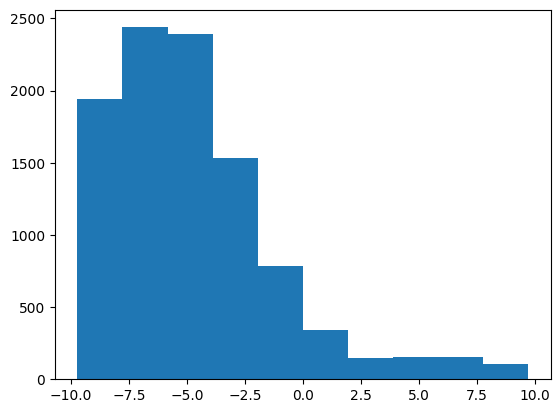

In [40]:
import matplotlib.pyplot as plt

plt.hist(llrn)

Define a numpy array `yp` of length `N`, that contains a 0 if the corresponding entry of `llrn` is negative, and a 1 if the corresponding entry of `llrn` is positive.

In [41]:
yp = np.where(llrn < 0, 0, 1)

Combine `df['y']` and `yp` into a two-column `pandas.DataFrame` called `yboth`

In [43]:
yboth = pd.DataFrame({'y': df['y'],
                     'yp': yp})

Take a peek at `yboth`

In [44]:
yboth.head()

,y,yp
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


Generate a 2x2 confusion matrix by calling `yboth.value_counts()`; assign that matrix to variable `cm`.

In [56]:
cm = yboth.value_counts()
cm

y  yp
0  0     9074
1  1      507
0  1      393
1  0       26
Name: count, dtype: int64

What the false positive error rate (defined by the count for `yp=1` and `y=0` over the marginal count for `y=0`):

In [ ]:
cm.loc[0,1]

np.int64(9074)

In [62]:
fpr = cm.loc[0,1]/(cm.loc[0,1] + cm.loc[0,0])
fpr

np.float64(0.04151262279497201)

What is the false negative error rate (defined by the count `yp=0` and `y=1` over the marginal count for `y=1`):

In [63]:
fnr = cm.loc[1,0]/(cm.loc[1,0] + cm.loc[1,1])
fnr

np.float64(0.04878048780487805)

What is the overall accuracy of the classifier, defined as the sum of the diagonal of the confusion matrix divided by `N`?

In [65]:
acc = (cm.loc[0,0] + cm.loc[1,1])/N
acc

np.float64(0.9581)